In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dsharp_opac as opacity
import emcee
import corner
import scipy
from multiprocess import Pool
from gofish import imagecube
from matplotlib.lines import Line2D

fortran mie routines unavailable


/data/discsim2/fz258/.conda/envs/bayesian_analysis/lib/python3.9/site-packages/dsharp_opac/dsharp_opac.py:42: UserWarning: could not import compiled mie code - mie calculation will be slow
  warnings.warn('could not import compiled mie code - mie calculation will be slow')


Find folder location at `module.__file__`.

In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

In [3]:
%matplotlib inline
%matplotlib notebook

In [4]:
plt.rcParams.update({'font.size': 14})

plt.rcParams.update({'axes.linewidth': 2.25})
plt.rcParams.update({'axes.labelpad': 5})

plt.rcParams.update({'xtick.major.size': 7.5})
plt.rcParams.update({'xtick.minor.size': 4.5})
plt.rcParams.update({'ytick.major.size': 7.5})
plt.rcParams.update({'ytick.minor.size': 4.5})

plt.rcParams.update({'xtick.major.width': 1.5})
plt.rcParams.update({'ytick.major.width': 1.5})
plt.rcParams.update({'xtick.minor.width': 1.5})
plt.rcParams.update({'ytick.minor.width': 1.5})

plt.rcParams.update({'xtick.major.pad': 5})
plt.rcParams.update({'ytick.major.pad': 5})

plt.rcParams.update({'xtick.top': True})
plt.rcParams.update({'ytick.right': True})
plt.rcParams.update({'xtick.labeltop': False})
plt.rcParams.update({'ytick.labelright': False})

plt.rcParams.update({'xtick.direction': "in"})
plt.rcParams.update({'ytick.direction': "in"})

Constants (from here: https://docs.astropy.org/en/stable/constants/index.html#module-astropy.constants)

In [5]:
au    = 1.49597871e+13         #cm
c_vel = 29979245800.0          #cm/s
h_pl  = 6.62607015e-27         #erg s
k_B   = 1.380649e-16           #erg/K
lsun  = 3.828e+33              #erg/s
s_SB  = 5.6703744191844314e-05 #g/K4/s3

Step 1: Load the data

In [6]:
disc_PA   = 11.28   #p.a. from Cathie's paper
disc_inc  = 49.24   #inclination from Cathie's paper
disc_dist = 160.318 #pc

In [7]:
def beam_to_sr(data, bmin, bmaj):
    """ Convert flux in Jy/beam to Jy/sr."""
    
    omega  = np.radians(bmin/3600.)
    omega *= np.radians(bmaj/3600.)
    
    beam_area = np.pi*omega*(4.*np.log(2.))**-1
    
    return data/beam_area

In [8]:
fac = 1 #reduction factor in total number of pixels

<IPython.core.display.Javascript object>


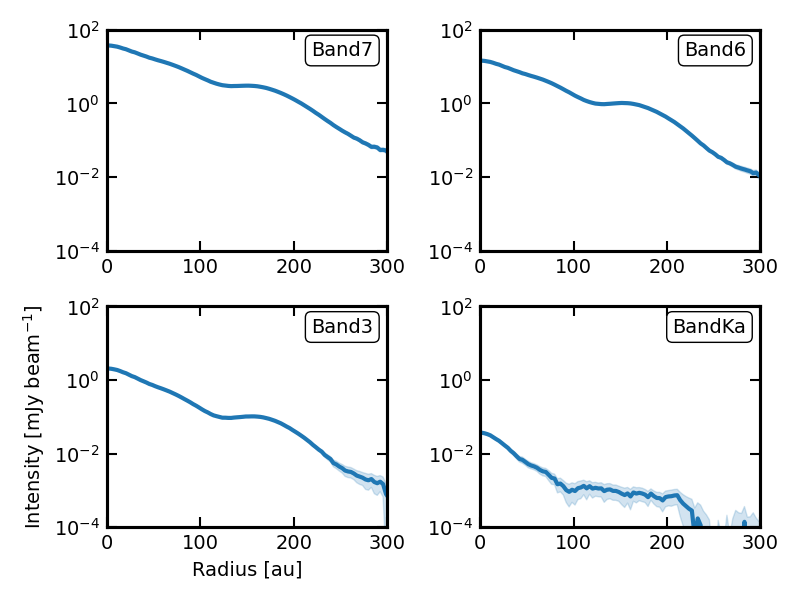

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


In [9]:
profiles_CITau = [
    '../CI_Tau_LB_band7_initcont_cent_0.75robust_1.0sigma_uvtapered_smoothed.image.tt0.fits',
    '../CI_Tau_LB_band6_new_initcont_cent_1.5robust_1.0sigma_uvtapered_smoothed.image.tt0.fits',
    '../CI_Tau_LB_band3_initcont_cent_PSsub_0.75robust_1.0sigma_uvtapered_smoothed.image.tt0.fits',
    '../CITau_VLA_Ka_PSsub_1.7Mlam_1.5robust_1.0sigma_uvtapered_smoothed.image.tt0.fits',
]

path_to_profiles = './'

label = ['Band7', 'Band6', 'Band3', 'BandKa']

fig, axs = plt.subplots(2,2,figsize=(8.,6.))
axs = axs.ravel()

dr = fac * 0.0195 #arcsec

for idx in range(len(profiles_CITau)):
    
    cube = imagecube(path_to_profiles + profiles_CITau[idx])
        
    x, y, dy = cube.radial_profile(inc=disc_inc, PA=disc_PA, dr=dr)
    
    y_b  = beam_to_sr(y, cube.bmin,cube.bmaj)
    dy_b = beam_to_sr(dy,cube.bmin,cube.bmaj)
    
    x  *= disc_dist #au
    y  *= 1e3  #mJy
    dy *= 1e3  #mJy
    
    l, = axs[idx].semilogy(x, y, lw=3., label=label[idx])
    axs[idx].fill_between(x, y - dy, y + dy, color=l.get_color(), alpha=0.2)

    np.savetxt(
        path_to_profiles + 'radprof_{}.dat'.format(label[idx]), np.array([x, y_b, dy_b]).T,
        header = 'Radius [au]\tIntensity [Jy/sr]\terror_Intensity [Jy/sr]'
    )
    
    axs[idx].set_xlim(0.,300.)
    axs[idx].set_ylim(1e-4,1e+2)
    
    axs[idx].text(0.95, 0.95, s=label[idx], ha='right', va='top', transform=axs[idx].transAxes, bbox=dict(boxstyle="round", ec="k", fc="w",))
    
    #print(cube.bmin,cube.bmaj) 

axs[2].set_xlabel(r'Radius [au]')
axs[2].set_ylabel(r'Intensity [mJy beam$^{-1}$]')

fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


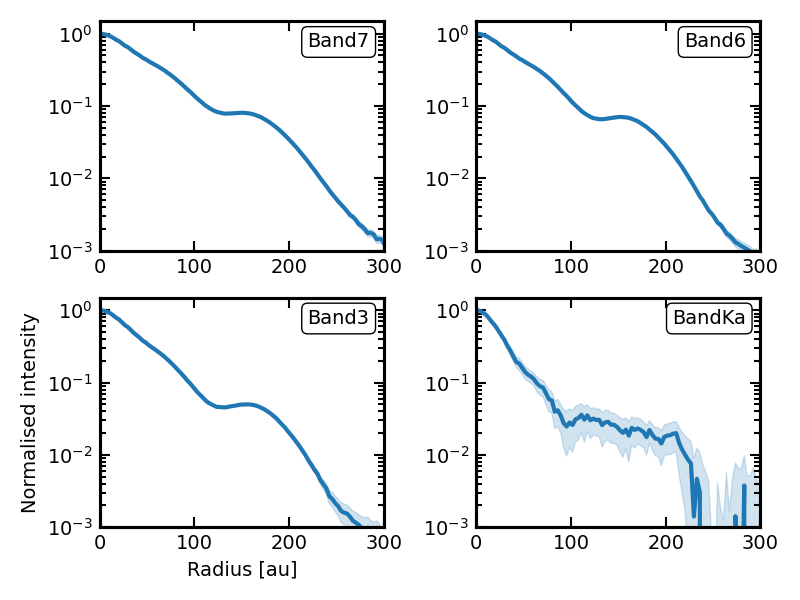

In [10]:
profiles_CITau = [
    'radprof_Band7.dat',
    'radprof_Band6.dat',
    'radprof_Band3.dat',
    'radprof_BandKa.dat',
]

path_to_profiles = './'
 
label  = ['Band7', 'Band6', 'Band3', 'BandKa']

rad_init = np.zeros(int(1200/fac))
inu_init = np.zeros((4,int(1200/fac)))
enu_init = np.zeros((4,int(1200/fac)))

fig, axs = plt.subplots(2,2,figsize=(8.,6.))
axs = axs.ravel()

for idx in range(len(profiles_CITau)):
    
    x, y, dy = np.loadtxt(path_to_profiles + profiles_CITau[idx], skiprows=1, usecols=(0,1,2), unpack=True)
    
    inu_init[idx] = y
    enu_init[idx] = dy
    
    l, = axs[idx].semilogy(x, y/y[0], lw=3., label=label[idx])
    axs[idx].fill_between(x, (y - dy)/y[0], (y + dy)/y[0], color=l.get_color(), alpha=0.2)
        
    axs[idx].set_xlim(0.,300.)
    axs[idx].set_ylim(1e-3,1.5)
    
    axs[idx].text(0.95, 0.95, s=label[idx], ha='right', va='top', transform=axs[idx].transAxes, bbox=dict(boxstyle="round", ec="k", fc="w",))
    
    #print(cube.bmin,cube.bmaj)
    
rad_init = x

axs[2].set_xlabel(r'Radius [au]')
axs[2].set_ylabel(r'Normalised intensity')

fig.tight_layout()
plt.show()

Step 2: Init the physical model

In [11]:
def BlackBody(nu, temp):
    """ 
    Returns Planck's function in Jy/sr.
    Parameters:
    nu:   frequency in GHz
    temp: temperature in K
    """
    den = np.exp(h_pl*nu*1e9/(k_B*temp)) - 1.
    num = 2.*h_pl*(nu*1e9)**3/c_vel**2  # in erg/cm^2 = erg/(cm^2*Hz*s*sr)

    planck = num/den
    return planck*1e23  # in Jy/sr

In [12]:
def scattering_function(omega, tau, mu=np.cos(disc_inc*np.pi/180.)):
    """
    Returns physical model for dust emission due to absorption and scattering (from slab's approximation).
    See e.g. Equation 3 of Macías et al. 2021.
    Parameters:
    omega: single-scattering albedo
    tau:   total optical depth
    mu:    cosine of the inclination
    """
    epsilon = (1. - omega)**0.5

    _a = np.exp(-np.sqrt(3.)*epsilon*tau)*(epsilon-1.) - (epsilon+1.)

    _b = (1. - np.exp(-(np.sqrt(3.)*epsilon+1./mu)*tau))/(np.sqrt(3.)*epsilon*mu + 1. + 1e-300)

    _c = (np.exp(-tau/mu)-np.exp(-np.sqrt(3.)*epsilon*tau))/(np.sqrt(3.)*epsilon*mu - 1. + 1e-300)

    _f = (_b+_c)/(_a + 1e-300)

    return 1. - np.exp(-tau/mu) + omega * _f

Benchmarking of scattering_function against Figure 1 of Zhu et al. 2019

<IPython.core.display.Javascript object>


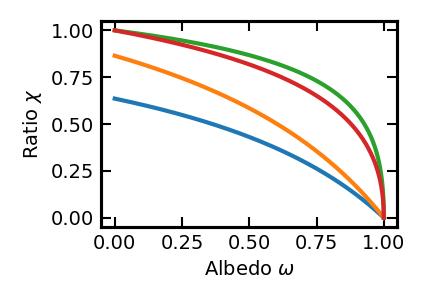

In [13]:
fig, axs = plt.subplots(figsize=(4.25,3))

omega = np.linspace(0,1,1000)

for _tau in [1.,100.]:
    for _mu in [0.99,0.5]:
    
        chi = scattering_function(omega=omega,tau=_tau,mu=_mu)
        
        axs.plot(omega,chi,lw=3.)

axs.set_xlabel(r'Albedo $\omega$')
axs.set_ylabel(r'Ratio $\chi$')

fig.tight_layout()
plt.show()

In [14]:
d         = np.load('/data/discsim2/fz258/dsharp_opac_notebook/datafiles/opacity_Ricci_compact(mine).npz')
a         = d['a']
lam       = d['lam']
k_abs     = d['k_abs']
k_sca     = d['k_sca']
gsca      = d['g']
k_sca_eff = (1 - gsca) * k_sca

In [15]:
def fitting_function(freq_avg, temp, lsigma, lamax, q):
    '''
    Returns intensity at a given radius in Jy/sr. See Macias et al. 2021 and Carrasco-Gonzalez et al. 2019.
    Parameters:
    freq_avg: average frequency of observations in GHz; *must be in decreasing order* (because size_averaga_opacity orders opacities with lambda)
    temp:     dust midplane temperature in K
    lsigma:   log10 of dust surface density in g/cm2
    lamax:    log10 of maximum grain size in cm
    q:        grain size 
    '''
    lam_avg   = c_vel/(freq_avg*1e9)
    res_eff   = opacity.size_average_opacity(lam_avg, a, lam, k_abs, k_sca_eff, q=q, plot=False)
    omg_eff   = res_eff['ks'] / (res_eff['ka'] + res_eff['ks']) #albedo
    opc_eff   = res_eff['ka'] + res_eff['ks']                   #total dust opacity (absorption + scattering)
    
    omg_init  = np.array([np.interp(lamax,np.log10(a),omg_eff[i]) for i in range(len(freq_avg))])
    opc_init  = np.array([np.interp(lamax,np.log10(a),opc_eff[i]) for i in range(len(freq_avg))])
    
    chi       = scattering_function(omega=omg_init,tau=opc_init*10.**lsigma)
    bb        = BlackBody(nu=freq_avg,temp=temp)
    
    inu_init  = bb * chi
    
    return inu_init

Input wavelengts [cm] = [0.08689636 0.12866629 0.20675342 0.30747944]
Albedo = [0.39309604 0.41364133 0.44791328 0.48159525]
Opacity [cm2/g] = [3.27624045 2.68949967 2.12472603 1.7430684 ]


<IPython.core.display.Javascript object>


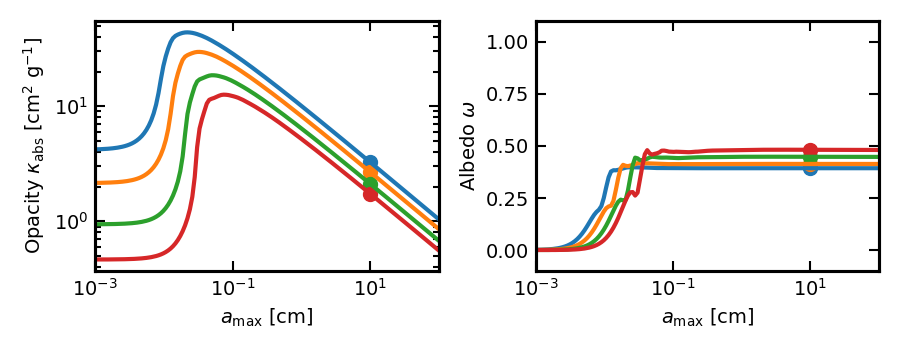

In [16]:
freq_avg  = np.array([345.,233.,145.,97.5]) #GHz
lamax     = 1                               #cm
q         = 3.5

lam_avg   = c_vel/(freq_avg*1e9)
print('Input wavelengts [cm] = {}'.format(lam_avg))

res_eff   = opacity.size_average_opacity(lam_avg, a, lam, k_abs, k_sca_eff, q=q, plot=False)

omg_eff   = res_eff['ks'] / (res_eff['ka'] + res_eff['ks']) #albedo
opc_eff   = res_eff['ka'] + res_eff['ks']                   #total dust opacity (absorption + scattering)
   
omg_init  = np.array([np.interp(lamax,np.log10(a),omg_eff[i]) for i in range(len(freq_avg))])
opc_init  = np.array([np.interp(lamax,np.log10(a),opc_eff[i]) for i in range(len(freq_avg))])

print('Albedo = {}'.format(omg_init))
print('Opacity [cm2/g] = {}'.format(opc_init))

fig, axs = plt.subplots(1,2,figsize=(9.,3.5))

for i in range(len(freq_avg)):
    axs[0].loglog(a,opc_eff[i],lw=3.)
    axs[0].scatter(10**lamax,opc_init[i],s=100)
    axs[1].semilogx(a,omg_eff[i],lw=3.)
    axs[1].scatter(10**lamax,omg_init[i],s=100)
    
axs[0].set_xlabel(r'$a_{\rm max}$ [cm]')
axs[0].set_ylabel(r'Opacity $\kappa_{\rm abs}$ [cm$^2$ g$^{-1}$]')
axs[1].set_xlabel(r'$a_{\rm max}$ [cm]')
axs[1].set_ylabel(r'Albedo $\omega$')

axs[0].set_xlim(1e-3,1e2)
axs[1].set_ylim(-0.1,1.1)
axs[1].set_xlim(1e-3,1e2)

fig.tight_layout()
plt.show()

Temperature prior:

In [17]:
def fintegrand(x,mean,sigma):
    """
    Returns normalised Gaussian by x (integrand of fpprob).
    Parameters:
    x:     interation variable
    mean:  Gaussian mean
    sigma: Gaussian stardard deviation
    """
    return (2*np.pi*sigma**2)**-0.5*np.exp(-0.5*(x - mean)**2/sigma**2) / x

def fpprob(z,R,k=0.25,xmin=0.01,xmax=0.06,mean=1.04*lsun,sigma=np.log(10)*0.20*1.04*lsun):
    """
    Returns the probability density function of the product of a uniform and Gaussian distribution.
    Good for temperature, as in equation 6 of Macias et al. 2021.
    Parameters:
    xmin, xmax: the domain of the uniform distribution (i.e. the disc flaring angles)
    mean:  Gaussian mean (i.e. the stellar average luminosity). From Gangi et al. 2022, see Table 2.
    sigma: Gaussian stardard deviation (i.e. the stellar luminosity error). From Gangi et al. 2022, see Table 2; error in log is converted as mean*ln(10)*err_log
    z:     the product variable (i.e. temperature in K)
    k:     the exponent factor (i.e. the exponent in eq. 6 of Macias et al. 2021)
    R:     the radius where the prior is computed in au
    """
    c = 1./(8.*np.pi*s_SB*(R*au)**2) 
    
    llim = z**(1./k)/(c*xmax)
    ulim = z**(1./k)/(c*xmin)
    
    return scipy.integrate.quad(func=fintegrand,a=llim,b=ulim,args=(mean,sigma))[0]*(xmax - xmin)**-1*z**(1./k - 1.)/(k*c)

Class for mcmc SED fitting:

In [18]:
class SED_optimizer(object):
    
    def __init__(self, pars, **kwargs):
        """ Initialises the SED optimizer from a dictionary of parameters. """
        
        self.pars = pars
        
        # Reference frequencies in GHz and decreasing order
        self.freq = self.pars['freq']  
        
        # Disc radius in au
        self.grid = self.pars['rad_grid'] 
        
        # Disc surface brightness and surface brightness uncertainty in Jy/sr
        self.surf_bright = self.pars['amean_sb'] 
        self.uncr_bright = self.pars['sigma_sb'] 
        
        # Calibration error at reference frequency
        cal_error = self.pars['calerror']

        # Final surface brightness uncertainty
        self.err_bright = np.hypot(self.uncr_bright,(self.surf_bright*cal_error.T))
        
    def lnpriorfn(self,theta):
        """ Prior probability function """

        for i in range(len(theta)):
            if theta[i] < self.theta_ranges[i][0] or theta[i] > self.theta_ranges[i][1]:
                return -np.inf
        
        #jacob = -theta[0]       # jacobian of the log transformation

        #return jacob
        return np.log(fpprob(z=theta[0], R=self.grid[self.bin_idx]))

    def lnpostfn(self,theta):
        """ Log of posterior probability function """

        lnprior = self.lnpriorfn(theta)  
        if not np.isfinite(lnprior):
            return -np.inf, -np.inf, -np.inf

        model = fitting_function(self.freq, *theta)
        error = self.err_bright[:,self.bin_idx]**2 #+ model**2 * np.exp(2*theta[-1])
        
        return -0.5 * np.sum((self.surf_bright[:,self.bin_idx] - model)**2/error + np.log(2*np.pi*error)) + lnprior, lnprior, theta[0]
    
    def run_fit(
        self,
        bin_idx, 
        nwalkers     = 40,    # number of walkers
        nsteps       = 1000,  # nuber of mcmc steps in each subroutine
        ntot         = 50000, # total number of mcmc steps
        nthreads     = 8,     # number of threads
        theta        = np.array([20., -2., 0., 3.5]), 
        theta_ranges = np.array([[1.,100.], [-3.,2.], [-3.,3.], [2.5,4.3]]),
        filename     = None,
        path         = './chains/',
        plot_corner  = False,
        **kwargs
    ):
        """
        Run the mcmc fit using emcee.
        Parameters:   
        bin_idx:      radial index
        nwalkers:     number of walkers
        nsteps:       nuber of mcmc steps in each subroutine
        ntot:         total number of mcmc steps
        nthreads:     number of threads
        theta:        initial positions where walkers are initialised 
        theta_ranges: range of allowed parameters
        filename:     output name
        path:         output folder
        plot_corner:  if draw the corner plot
            showplot:    if show the corner plot
            truths:      expected median of posterior distributions
            plot_ranges: corner plot ranges
            check_theta: plot best fit theta
        Returns: .hdf5 file with param chains.
        """
        
        showplot     = kwargs.get('showplot', False)
        truths       = kwargs.get('truths', None)
        plot_ranges  = kwargs.get('plot_ranges', [(1.,100.),(-3.,2.),(-3.,3.),(1.,5.)])
        check_theta  = kwargs.get('check_theta', False)
        
        self.bin_idx = bin_idx
        self.theta_ranges = theta_ranges
        
        ndim         = len(theta_ranges)  # number of dimensions
        
        print('Fitting SED at {} au'.format(self.grid[bin_idx]))

        # Observed intensity at reference radius
        inu_init = self.surf_bright[:,bin_idx]
        print('SED data = {}'.format(inu_init))

        # Uncertainty at reference radius
        inu_err = self.err_bright[:,bin_idx]
        print('Per cent error = {}'.format(inu_err/inu_init*100))
        
        # Find theta using a maximum likelihood argument when not provided
        if not list(theta):
            temp = np.linspace(1,150,1000)

            prior = np.zeros(len(temp))
            for t_idx, _t in enumerate(temp):
                prior[t_idx] = fpprob(z=_t, R=self.grid[self.bin_idx])
            
            bb = temp[prior==np.amax(prior)]
            
            bound_min = np.hstack((bb - 3,theta_ranges[1:,0]))
            bound_max = np.hstack((bb + 3,theta_ranges[1:,1]))
            
            theta, _ = scipy.optimize.curve_fit(
                f        = fitting_function, 
                xdata    = self.freq, 
                ydata    = inu_init,
                bounds   = (bound_min, bound_max),
                max_nfev = 10000
            )
            
            # Flag to plot the results of the fitting routine
            if check_theta:
                fig, axs = plt.subplots(figsize=(5,4))
                
                axs.errorbar(self.freq, inu_init, yerr=inu_err, lw=2, marker='o', ms=10, ls='none', capsize=10, mew=2, color='C0')
                axs.scatter(self.freq, fitting_function(self.freq, *theta), color='C1', marker='o', ms=50)
                
                axs.set_xlabel(r'Frequency [GHz]')
                axs.set_ylabel(r'Intensity [Jy sr$^{-1}$]')
                
                fig.tight_layout()
                plt.show()
            
            # If the maximum grain size is too close to the maximum value allowed, shift it a bit inside
            # if np.logical_and(theta_ranges[2,1] - theta[2] < 0.5, theta_ranges[2,1] > 0):
            #    theta[2] = 0
            
            theta = np.hstack((bb,theta[1:]))
            #theta = np.hstack((theta,0))
            
        print('Initial guess = {}'.format(theta))
        
        # Check that your walkers are initialised within the ranges
        if self.lnpriorfn(theta) == -np.inf:
            print("""You have initialized walkers outside of the bounds. The chains will return a NaN!""")
            return
        
        # Randomise initial position of walkers
        pos = [theta + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

        # Set up the backend and clear it in case the file already exists
        if not filename:
            filename = path + "CITau_SEDfit_{}.hdf5".format(self.grid[bin_idx])
        
        backend = emcee.backends.HDFBackend(filename)
        backend.reset(nwalkers, ndim)

        print("Initial file size: {}".format(backend.iteration))

        # Track how the average autocorrelation time and acceptance franction estimate changes
        index    = 0
        autocorr = np.zeros(int(ntot/nsteps))
        acptfrac = np.zeros(int(ntot/nsteps))
        
        # Check convergence
        old_tau  = np.inf

        # Run mcmc
        with Pool(processes = nthreads) as pool:

            prob, state = None, None
            for i in range(nsteps, ntot + 1, nsteps):

                backend_i = emcee.backends.HDFBackend(filename)

                sampler_i = emcee.EnsembleSampler(
                    nwalkers, ndim, self.lnpostfn, pool = pool, backend = backend_i,
                    # args = [theta_ranges, bin_idx],
                    moves = [
                        (emcee.moves.DEMove(), 0.8),
                        (emcee.moves.DESnookerMove(), 0.2),
                    ],
                    blobs_dtype = [("log_prior", float), ("temp", float)],
                )

                pos, prob, state, blobs = sampler_i.run_mcmc(pos, nsteps, progress=True)
                
                acptfrac[index] = np.mean(sampler_i.acceptance_fraction)
                
                # Compute the autocorrelation time so far
                tau = sampler_i.get_autocorr_time(tol=0)
                autocorr[index] = np.amax(tau)
                index += 1

                # Check convergence
                converged = np.all(tau*100. < sampler_i.iteration)
                converged &= np.all(np.abs(old_tau - tau)/tau <= 0.01)

                if converged:
                    break

                old_tau = tau

        print("Final file size: {}".format(backend.iteration))
        
        np.savetxt(
            fname = filename.split('.hdf5')[0] + "_autocorr.dat", 
            X = np.array(list(autocorr)),
            header = 'autocorr_time,\tnsteps={}'.format(nsteps),
        )
        
        np.savetxt(
            fname = filename.split('.hdf5')[0] + "_acptfrac.dat", 
            X = np.array(list(acptfrac)),
            header = 'acceptance_fraction,\tnsteps={}'.format(nsteps),
        )
        
        if plot_corner:
            # Choose to show the maximum-likelihood solution as a reference for the true value when missing
            if not truths:
                truths = theta
            
            self.plot(filename, saveplot=True, showplot=showplot, bin_idx=self.bin_idx, truths=truths, plot_ranges=plot_ranges)
            
    def plot(self, filename, saveplot=False, showplot=False, path='./corner_plots/', **kwargs):
        """ 
        Plot posteriors using a triangle plot.
        Parameters:
        filename: output name
        saveplot: if save corner plot
        showplot: if show the corner plot
        path:     output folder
            bin_idx:     radial index
            truths:      expected median of posterior distributions
            plot_ranges: corner plot ranges
        """
        
        bin_idx     = kwargs.get('bin_idx', None)
        truths      = kwargs.get('truths', None)
        plot_ranges = kwargs.get('plot_ranges', [(0.,100.),(-3.,1.5),(-3.,2.),(1.,5.)])
        
        reader  = emcee.backends.HDFBackend(filename, read_only=True)
        
        try:
            tau     = reader.get_autocorr_time()
        except emcee.autocorr.AutocorrError: 
            tau     = reader.get_autocorr_time(tol=0)
            print('The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = {}) with caution and run a longer chain!'.format(np.amax(tau)))

        burnin  = int(3 * np.max(tau))
        thin    = int(0.5 * np.min(tau))       

        samples = reader.get_chain()
        flat_samples = reader.get_chain(discard=burnin, thin=thin, flat=True)
        
        labels   = [
                r"$T$ [K]", 
                r"$\log(\Sigma/{\rm cm}^2\,{\rm g}^{-1})$",
                r"$\log(a_{\rm max}/{\rm cm})$",
                r"$q$",
                #r"$\ln f$",
        ]
        
        fig, axs = plt.subplots(len(labels), 1, figsize=(10, 10), sharex=True)
        
        for i in range(len(labels)):
            axs[i].plot(samples[:, :, i], "C0", alpha=0.1)
            axs[i].axvline(burnin, c='C1', ls='--')
            
            axs[i].set_xlim(0, len(samples))
            axs[i].set_ylabel(labels[i])
            axs[i].yaxis.set_label_coords(-0.1, 0.5)
            #axs[i].set_ylim(plot_ranges[i])
            
        axs[-1].set_xlabel('# steps')
        fig.tight_layout()
        
        fig.savefig(path + "CITau_SEDfit_chains_{}.pdf".format(self.grid[bin_idx]), bbox_inches='tight')
        plt.close()
        plt.ioff()
        
        flat_blobs = reader.get_blobs(discard=burnin, thin=thin, flat=True)
        flat_log_prior_samples = flat_blobs["log_prior"]
        flat_temp              = flat_blobs["temp"]
        
        fig = corner.corner(
            data             = flat_samples, 
            range            = plot_ranges,
            color            = 'C0',
            smooth           = False, 
            smooth1d         = False,
            labels           = labels,
            label_kwargs     = {'fontsize':13},
            # titles           = [
            #    r"$T/{\rm K}$", 
            #    r"$\log(\Sigma/{\rm cm}^2\,{\rm g}^{-1})$",
            #    r"$\log(a_{\rm max}/{\rm cm})$",
            #    r"$q$"
            # ],
            show_titles      = False, 
            title_kwargs     = {'fontsize':10}, 
            # truths           = truths,
            truth_color      = 'C1',
            quantiles        = [0.16, 0.50, 0.84],
            quantile_color   = 'k',
            labelpad         = 0.0,
            verbose          = False,
            top_ticks        = False,
            hist_density     = True,
        )

        pprior = []
        temp   = np.linspace(1.,100.,1000)
        for _t in temp:
            pprior.append(fpprob(z=_t,R=self.grid[bin_idx]))
    
        axs = fig.axes
        
        axs[0].plot(temp, pprior, c='C2', lw=2)
        flat_log_prior_samples = np.array([flat_log_prior_samples for _, flat_log_prior_samples in sorted(zip(flat_temp, flat_log_prior_samples))])
        axs[0].plot(sorted(flat_temp), np.exp(flat_log_prior_samples), color='gray', ls='--', lw=2)
  
        axs[0].set_ylim(0., np.amax(pprior) + 0.005)
                
        if saveplot:
            fig.savefig(path + "CITau_SEDfit_{}.pdf".format(self.grid[bin_idx]), bbox_inches='tight')
        
        if showplot:
            plt.show()
        else:
            plt.close()
            plt.ioff()

Fitting SED:

Fitting SED at 1.5631005000000002 au
SED data = [3.75299727e+10 1.44988426e+10 2.04032256e+09 3.67019400e+07]
Per cent error = [10. 10.  5. 10.]
Initial guess = [115.99399399  -0.76824594   2.00000023   3.42796763]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:48<00:00,  1.08s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 119.87278843795195) with caution and run a longer chain!


<IPython.core.display.Javascript object>


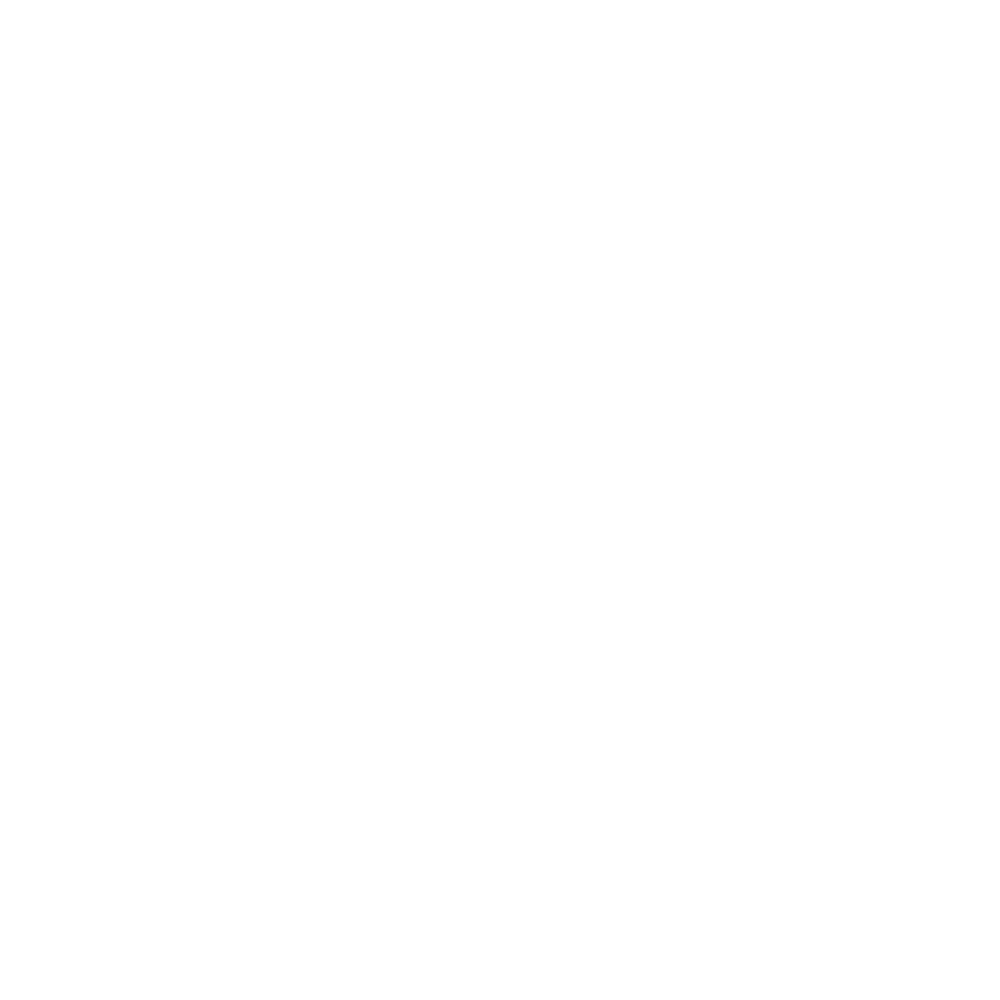

Fitting SED at 4.6893015 au
SED data = [3.69587855e+10 1.42676152e+10 2.00317581e+09 3.54266080e+07]
Per cent error = [10.01423089 10.01644282  5.0428702  10.17533943]
Initial guess = [66.92392392 -0.69105881  2.00000012  3.49062338]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:09<00:00,  1.29s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 118.59076317285317) with caution and run a longer chain!


Fitting SED at 7.815502500000001 au
SED data = [3.58598410e+10 1.38254848e+10 1.93416448e+09 3.35186080e+07]
Per cent error = [10.00783098 10.01205912  5.02769967 10.29473171]
Initial guess = [51.85985986 -0.7045356   2.00000042  3.53884105]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:00<00:00,  1.21s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 117.80853378598545) with caution and run a longer chain!


Fitting SED at 10.941703500000001 au
SED data = [3.47556536e+10 1.33789245e+10 1.85729434e+09 3.11401880e+07]
Per cent error = [10.1252822  10.13593365  5.34010102 10.45079318]
Initial guess = [43.80580581 -0.74117809  2.0000841   3.58079149]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:06<00:00,  1.27s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 109.26022862368649) with caution and run a longer chain!


Fitting SED at 14.067904500000001 au
SED data = [3.29931551e+10 1.26679173e+10 1.73915315e+09 2.76697700e+07]
Per cent error = [10.12034272 10.12824626  5.308617   10.37648765]
Initial guess = [38.58558559 -0.79661708  1.99999834  3.61882963]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:08<00:00,  1.29s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 103.79454586405912) with caution and run a longer chain!


Fitting SED at 17.194105500000003 au
SED data = [3.10372946e+10 1.18825021e+10 1.61230630e+09 2.45856400e+07]
Per cent error = [10.14555788 10.15469674  5.37325387 10.58947523]
Initial guess = [35.00600601 -0.85500231  2.00000034  3.65102119]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:59<00:00,  1.19s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 110.20597254726802) with caution and run a longer chain!


Fitting SED at 20.3203065 au
SED data = [2.96019579e+10 1.13056092e+10 1.51894810e+09 2.20277020e+07]
Per cent error = [10.27032405 10.28762232  5.67714399 10.63865956]
Initial guess = [32.17217217 -0.90606866  1.99999924  3.68128781]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:08<00:00,  1.28s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 101.97162642343068) with caution and run a longer chain!


Fitting SED at 23.4465075 au
SED data = [2.75264369e+10 1.04774011e+10 1.38704704e+09 1.90334100e+07]
Per cent error = [10.26306303 10.27607301  5.64930085 11.06159711]
Initial guess = [29.93493493 -0.96620569  1.999995    3.70795134]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:14<00:00,  1.34s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 107.49591502348581) with caution and run a longer chain!


Fitting SED at 26.572708500000005 au
SED data = [2.56063201e+10 9.71589734e+09 1.26698573e+09 1.64207920e+07]
Per cent error = [10.26258465 10.27525078  5.67267668 11.92201601]
Initial guess = [28.14514515 -1.02118525  2.00000086  3.7308449 ]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:20<00:00,  1.40s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 95.62229470048382) with caution and run a longer chain!


Fitting SED at 29.698909500000003 au
SED data = [2.44064645e+10 9.24326400e+09 1.19099430e+09 1.42687920e+07]
Per cent error = [10.29656992 10.31233511  5.77784243 12.55828023]
Initial guess = [26.65365365 -1.06080777  2.00000079  3.75156188]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:12<00:00,  1.32s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 102.874832166624) with caution and run a longer chain!


Fitting SED at 32.8251105 au
SED data = [2.27150684e+10 8.58351872e+09 1.08619469e+09 1.17794330e+07]
Per cent error = [10.22229092 10.23355729  5.6070911  14.56169682]
Initial guess = [25.31131131 -1.10679772  1.99999396  3.7695258 ]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:13<00:00,  1.34s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 86.98165495682082) with caution and run a longer chain!


Fitting SED at 35.9513115 au
SED data = [2.10902733e+10 7.95925606e+09 9.89023104e+08 1.01594770e+07]
Per cent error = [10.20281944 10.21251335  5.58300165 16.64554078]
Initial guess = [24.11811812 -1.14672437  2.0000001   3.78379726]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:11<00:00,  1.32s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 87.69275961606587) with caution and run a longer chain!


Fitting SED at 39.077512500000005 au
SED data = [1.98808576e+10 7.49613926e+09 9.16636352e+08 8.43516300e+06]
Per cent error = [10.19188925 10.20180841  5.57110325 18.08177627]
Initial guess = [23.22322322 -1.17777992  2.00000134  3.79501728]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:01<00:00,  1.22s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 75.72734564122909) with caution and run a longer chain!


Fitting SED at 42.2037135 au
SED data = [1.87238994e+10 7.05685658e+09 8.48031680e+08 7.08289750e+06]
Per cent error = [10.1258232  10.13193947  5.39175962 19.75145402]
Initial guess = [22.32832833 -1.20723431  1.99999843  3.80603559]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:01<00:00,  1.22s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 82.79860055682481) with caution and run a longer chain!


Fitting SED at 45.3299145 au
SED data = [1.74237430e+10 6.56341555e+09 7.74472448e+08 6.69411550e+06]
Per cent error = [10.10132988 10.10781787  5.34724639 21.82647919]
Initial guess = [21.58258258 -1.23857803  1.9999982   3.81357798]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:00<00:00,  1.21s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 71.56157704226113) with caution and run a longer chain!


Fitting SED at 48.45611550000001 au
SED data = [1.66284175e+10 6.26324480e+09 7.29200192e+08 5.87752450e+06]
Per cent error = [10.10410545 10.1092055   5.35946038 21.13016384]
Initial guess = [20.83683684 -1.26126755  1.99999954  3.82398743]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:07<00:00,  1.28s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 73.40705000930322) with caution and run a longer chain!


Fitting SED at 51.5823165 au
SED data = [1.56498248e+10 5.88825856e+09 6.73755584e+08 5.12672850e+06]
Per cent error = [10.05513166 10.05668517  5.22386682 22.66942705]
Initial guess = [20.24024024 -1.29097563  2.00000005  3.83266553]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:59<00:00,  1.20s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 76.9075883853627) with caution and run a longer chain!


Fitting SED at 54.708517500000006 au
SED data = [1.48001280e+10 5.56529203e+09 6.28781248e+08 4.69830950e+06]
Per cent error = [10.04050718 10.04276281  5.19886848 21.45802051]
Initial guess = [19.64364364 -1.31650042  2.00009109  3.84100447]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:02<00:00,  1.22s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 70.82876783921628) with caution and run a longer chain!


Fitting SED at 57.83471850000001 au
SED data = [1.40809247e+10 5.28691763e+09 5.90453504e+08 4.43581700e+06]
Per cent error = [10.03345605 10.03290192  5.16366623 21.67754072]
Initial guess = [19.04704705 -1.34394021  2.00453121  3.8527465 ]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:07<00:00,  1.27s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 51.424165955876425) with caution and run a longer chain!


Fitting SED at 60.9609195 au
SED data = [1.33506191e+10 4.99847219e+09 5.51650240e+08 4.06941850e+06]
Per cent error = [10.01597019 10.01529288  5.10178424 22.41735438]
Initial guess = [18.5995996  -1.37598194  2.00000004  3.86412271]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:00<00:00,  1.21s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 68.76710992584137) with caution and run a longer chain!


Fitting SED at 64.0871205 au
SED data = [1.25981798e+10 4.70316544e+09 5.13554144e+08 3.56482725e+06]
Per cent error = [10.0151989  10.01705907  5.09698361 25.37014225]
Initial guess = [18.15215215 -1.40880482  2.00000011  3.87528623]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:00<00:00,  1.20s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 61.24605031165452) with caution and run a longer chain!


Fitting SED at 67.2133215 au
SED data = [1.18966620e+10 4.42322586e+09 4.77619968e+08 3.26067800e+06]
Per cent error = [10.01994165 10.02085152  5.10209994 26.51969686]
Initial guess = [17.7047047  -1.44492457  2.00001916  3.8896562 ]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:03<00:00,  1.24s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 67.1462320813445) with caution and run a longer chain!


Fitting SED at 70.3395225 au
SED data = [1.11362478e+10 4.11194189e+09 4.38185088e+08 3.14283600e+06]
Per cent error = [10.01780146 10.01937679  5.09449263 26.83297693]
Initial guess = [17.25725726 -1.4918459   2.00000088  3.90989927]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:59<00:00,  1.20s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 59.49110625926769) with caution and run a longer chain!


Fitting SED at 73.46572350000001 au
SED data = [1.04078735e+10 3.81564902e+09 4.02822816e+08 2.62479850e+06]
Per cent error = [10.02438818 10.02706741  5.12575968 32.02830954]
Initial guess = [16.95895896 -1.53708313  2.00000437  3.92661979]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:58<00:00,  1.19s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 66.4885811901528) with caution and run a longer chain!


Fitting SED at 76.5919245 au
SED data = [9.70306458e+09 3.52445082e+09 3.67758688e+08 2.16835050e+06]
Per cent error = [10.02589688 10.02934111  5.14883988 34.71292035]
Initial guess = [16.51151151 -1.58539294  1.99999687  3.9520566 ]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:47<00:00,  1.08s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 61.364686246325505) with caution and run a longer chain!


Fitting SED at 79.7181255 au
SED data = [8.97475277e+09 3.22362573e+09 3.33377376e+08 2.07796088e+06]
Per cent error = [10.0248343  10.02988042  5.16348225 33.75799123]
Initial guess = [16.21321321 -1.63729836  1.99999417  3.97698795]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:57<00:00,  1.18s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 67.92811796742909) with caution and run a longer chain!


Fitting SED at 82.84432650000001 au
SED data = [8.27836621e+09 2.93643930e+09 3.01055872e+08 1.45170188e+06]
Per cent error = [10.0331354  10.04311028  5.21083504 42.8682687 ]
Initial guess = [15.91491491 -1.68411358  1.9999895   4.        ]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:59<00:00,  1.19s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 66.14964666393007) with caution and run a longer chain!


Fitting SED at 85.9705275 au
SED data = [7.64894771e+09 2.67951744e+09 2.72647200e+08 1.51638688e+06]
Per cent error = [10.03756642 10.05514262  5.27679424 41.83934009]
Initial guess = [15.61661662 -1.92382973 -0.79513879  4.        ]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:58<00:00,  1.18s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 44.75720052475567) with caution and run a longer chain!


Fitting SED at 89.0967285 au
SED data = [7.00979712e+09 2.42400512e+09 2.45993152e+08 1.29255100e+06]
Per cent error = [10.04099615 10.06063845  5.29891264 43.68453044]
Initial guess = [15.31831832 -1.97209455 -1.01692308  4.        ]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:00<00:00,  1.20s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 40.12309463176071) with caution and run a longer chain!


Fitting SED at 92.2229295 au
SED data = [6.42524672e+09 2.18826266e+09 2.19304352e+08 1.00808750e+06]
Per cent error = [10.04662353 10.06695894  5.30400754 55.24217918]
Initial guess = [15.02002002 -2.01614372 -1.24562047  4.        ]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:57<00:00,  1.17s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 44.93538869069912) with caution and run a longer chain!


Fitting SED at 95.3491305 au
SED data = [5.93450496e+09 1.99749274e+09 1.98662224e+08 9.03584250e+05]
Per cent error = [10.05472251 10.08357298  5.41463897 61.91186722]
Initial guess = [14.87087087 -2.05047356 -1.3065328   3.99999438]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:58<00:00,  1.19s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 36.88774471448927) with caution and run a longer chain!


Fitting SED at 98.4753315 au
SED data = [5.40568883e+09 1.79815078e+09 1.77694720e+08 1.02915125e+06]
Per cent error = [10.05520758 10.08133031  5.45702617 55.48017972]
Initial guess = [14.57257257 -2.08445554 -1.34170845  3.99910928]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:55<00:00,  1.16s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 41.4016210444869) with caution and run a longer chain!


Fitting SED at 101.60153250000002 au
SED data = [4.92837786e+09 1.61965427e+09 1.58285120e+08 9.48935500e+05]
Per cent error = [10.06430676 10.08643527  5.51597096 59.23610386]
Initial guess = [14.42342342 -2.1216819  -1.38132589  4.        ]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:56<00:00,  1.17s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 33.17738313090681) with caution and run a longer chain!


Fitting SED at 104.72773350000001 au
SED data = [4.54791680e+09 1.47945446e+09 1.42259600e+08 1.13541450e+06]
Per cent error = [10.08414798 10.10216517  5.61509054 52.10663726]
Initial guess = [14.12512513 -2.14576149 -1.47377653  4.        ]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:54<00:00,  1.14s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 38.8971853627982) with caution and run a longer chain!


Fitting SED at 107.85393450000001 au
SED data = [4.21010586e+09 1.35901376e+09 1.30413832e+08 1.18686488e+06]
Per cent error = [10.07859329 10.0946359   5.70636779 51.28209689]
Initial guess = [13.97597598 -2.17531039 -1.48241207  3.99997449]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:54<00:00,  1.14s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 35.17083818470016) with caution and run a longer chain!


Fitting SED at 110.98013550000002 au
SED data = [3.86668698e+09 1.23799078e+09 1.17799280e+08 1.31339638e+06]
Per cent error = [10.08912101 10.09380568  5.69979389 43.91881344]
Initial guess = [13.82682683 -2.20872821 -1.48241217  3.99975673]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:55<00:00,  1.15s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 28.124747286248912) with caution and run a longer chain!


Fitting SED at 114.10633650000001 au
SED data = [3.63184154e+09 1.15375373e+09 1.08336944e+08 1.12369712e+06]
Per cent error = [10.10199253 10.10651528  5.72088761 52.20591452]
Initial guess = [13.52852853 -2.22434244 -1.49445429  4.        ]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:56<00:00,  1.16s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 29.90371637202461) with caution and run a longer chain!


Fitting SED at 117.2325375 au
SED data = [3.41779430e+09 1.08402586e+09 1.02963336e+08 1.29048700e+06]
Per cent error = [10.09405954 10.10372063  5.80711416 41.02445311]
Initial guess = [13.37937938 -2.24563126 -1.49649835  4.        ]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:53<00:00,  1.14s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 27.74958532886082) with caution and run a longer chain!


Fitting SED at 120.35873850000002 au
SED data = [3.25178598e+09 1.02912947e+09 9.81889760e+07 1.10572000e+06]
Per cent error = [10.09238943 10.09578753  5.62053542 45.82618021]
Initial guess = [13.23023023 -2.26174282 -1.5003095   4.        ]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:54<00:00,  1.15s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 27.63382232688156) with caution and run a longer chain!


Fitting SED at 123.48493950000001 au
SED data = [3.11365018e+09 9.85552192e+08 9.37744000e+07 1.16307188e+06]
Per cent error = [10.08843431 10.09041831  5.58600529 42.19153276]
Initial guess = [13.08108108 -2.27483419 -1.50208412  4.        ]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:56<00:00,  1.16s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 29.06730938536187) with caution and run a longer chain!


Fitting SED at 126.6111405 au
SED data = [3.04473907e+09 9.69070144e+08 9.36850640e+07 1.11330225e+06]
Per cent error = [10.08103138 10.07994375  5.55194547 41.47511547]
Initial guess = [12.93193193 -2.27841504 -1.49565451  4.        ]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:55<00:00,  1.15s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 28.90014637948163) with caution and run a longer chain!


Fitting SED at 129.7373415 au
SED data = [2.97790157e+09 9.52923712e+08 9.25331280e+07 1.12218250e+06]
Per cent error = [10.07380086 10.06749779  5.47499415 43.25635788]
Initial guess = [12.78278278 -2.28176694 -1.49052877  4.        ]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:57<00:00,  1.17s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 25.18846183601355) with caution and run a longer chain!


Fitting SED at 132.8635425 au
SED data = [2.93841971e+09 9.48851200e+08 9.23909600e+07 9.45258312e+05]
Per cent error = [10.06802464 10.05302704  5.43889046 51.38337884]
Initial guess = [12.63363363 -2.28142886 -1.48241208  3.99949699]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:57<00:00,  1.18s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 33.05421656070888) with caution and run a longer chain!


Fitting SED at 135.9897435 au
SED data = [2.95839744e+09 9.62670208e+08 9.45157600e+07 1.03284256e+06]
Per cent error = [10.05629299 10.03555329  5.38302895 46.71433881]
Initial guess = [12.48448448 -2.27079683 -1.48241206  3.9998089 ]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:56<00:00,  1.17s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 37.961646681619754) with caution and run a longer chain!


Fitting SED at 139.1159445 au
SED data = [2.96435738e+09 9.73819328e+08 9.59826000e+07 1.05059412e+06]
Per cent error = [10.0478364  10.02749809  5.35491815 45.27295785]
Initial guess = [12.33533534 -2.26269847 -1.48241193  3.99950206]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:57<00:00,  1.17s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 28.189789328237346) with caution and run a longer chain!


Fitting SED at 142.24214550000002 au
SED data = [2.98508083e+09 9.88655488e+08 9.73259280e+07 9.58705500e+05]
Per cent error = [10.03757749 10.02171893  5.3563156  45.57938225]
Initial guess = [12.18618619 -2.2518128  -1.47427816  4.        ]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:57<00:00,  1.17s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 33.32726314907468) with caution and run a longer chain!


Fitting SED at 145.3683465 au
SED data = [3.00437939e+09 1.00248896e+09 9.90274880e+07 9.56470438e+05]
Per cent error = [10.0335088  10.01972823  5.34145708 45.68079248]
Initial guess = [12.03703704 -2.24155829 -1.46510783  4.        ]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:57<00:00,  1.17s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 32.42364277991591) with caution and run a longer chain!


Fitting SED at 148.4945475 au
SED data = [3.02048307e+09 1.01500909e+09 1.00992104e+08 8.93335062e+05]
Per cent error = [10.0269138  10.02411514  5.34363438 45.31818609]
Initial guess = [11.88788789 -2.23262083 -1.38930272  4.        ]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:56<00:00,  1.17s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 33.65798043693587) with caution and run a longer chain!


Fitting SED at 151.62074850000002 au
SED data = [3.02447155e+09 1.02412826e+09 1.01160016e+08 8.03313312e+05]
Per cent error = [10.02433412 10.02874018  5.38228478 50.68052224]
Initial guess = [11.73873874 -2.22375534 -1.4339821   4.        ]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:59<00:00,  1.20s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 37.78557513076644) with caution and run a longer chain!


Fitting SED at 154.7469495 au
SED data = [2.99705958e+09 1.01699181e+09 1.01743432e+08 7.39013062e+05]
Per cent error = [10.02407078 10.03501703  5.35421054 55.11829671]
Initial guess = [11.58958959 -2.22045022 -1.35327188  4.        ]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:58<00:00,  1.18s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 34.16179180949684) with caution and run a longer chain!


Fitting SED at 157.8731505 au
SED data = [2.96381082e+09 1.01038099e+09 1.01649160e+08 8.18223625e+05]
Per cent error = [10.02719268 10.04496569  5.39359282 46.62615478]
Initial guess = [11.58958959 -2.22526426 -1.34170855  3.99991097]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:58<00:00,  1.19s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 36.48201052147949) with caution and run a longer chain!


Fitting SED at 160.99935150000002 au
SED data = [2.90845798e+09 9.93813824e+08 1.00304568e+08 6.75841938e+05]
Per cent error = [10.02651185 10.04429011  5.4068784  57.43878804]
Initial guess = [11.44044044 -2.22649811 -1.34170875  3.99944176]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:56<00:00,  1.16s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 36.37389423155361) with caution and run a longer chain!


Fitting SED at 164.12555250000003 au
SED data = [2.82122163e+09 9.64361664e+08 9.85156160e+07 8.68179562e+05]
Per cent error = [10.02903194 10.0526135   5.42952245 43.4812732 ]
Initial guess = [11.29129129 -2.23216583 -1.34170858  3.99994819]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:02<00:00,  1.23s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 30.37684133013111) with caution and run a longer chain!


Fitting SED at 167.2517535 au
SED data = [2.72535936e+09 9.29286912e+08 9.54696000e+07 8.10540375e+05]
Per cent error = [10.03321067 10.05862139  5.43217136 45.35064821]
Initial guess = [11.14214214 -2.24022869 -1.35083369  4.        ]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:59<00:00,  1.20s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 34.842651032693254) with caution and run a longer chain!


Fitting SED at 170.3779545 au
SED data = [2.62009498e+09 8.93688704e+08 9.14338480e+07 8.49375000e+05]
Per cent error = [10.03173934 10.04964739  5.47217203 40.30786961]
Initial guess = [11.14214214 -2.25814333 -1.34837791  4.        ]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:59<00:00,  1.19s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 31.737150602770036) with caution and run a longer chain!


Fitting SED at 173.50415550000002 au
SED data = [2.48543462e+09 8.41155200e+08 8.73409840e+07 8.13679250e+05]
Per cent error = [10.03298704 10.05695431  5.48741348 41.14160548]
Initial guess = [10.99299299 -2.27479883 -1.39477931  4.        ]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:58<00:00,  1.19s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 33.38402603570589) with caution and run a longer chain!


Fitting SED at 176.6303565 au
SED data = [2.34654310e+09 7.90351104e+08 8.21531440e+07 7.56671312e+05]
Per cent error = [10.03642684 10.06404412  5.43284943 40.25418744]
Initial guess = [10.84384384 -2.29152496 -1.47552796  4.        ]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:59<00:00,  1.20s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 33.92926244213258) with caution and run a longer chain!


Fitting SED at 179.75655749999999 au
SED data = [2.21019520e+09 7.43736448e+08 7.71307760e+07 6.47112625e+05]
Per cent error = [10.03376233 10.05165899  5.47714885 45.3064038 ]
Initial guess = [10.84384384 -2.3187018  -1.4754221   4.        ]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:58<00:00,  1.19s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 32.392223206401695) with caution and run a longer chain!


Fitting SED at 182.88275850000005 au
SED data = [2.06120422e+09 6.86283072e+08 7.13512560e+07 8.09701062e+05]
Per cent error = [10.03971221 10.0668464   5.49215237 35.57635988]
Initial guess = [10.69469469 -2.34545121 -1.48241207  3.99652418]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:57<00:00,  1.17s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 31.788417848068967) with caution and run a longer chain!


Fitting SED at 186.0089595 au
SED data = [1.91527194e+09 6.33693632e+08 6.59786800e+07 6.88729250e+05]
Per cent error = [10.04241173 10.07257285  5.48358633 40.02465053]
Initial guess = [10.69469469 -2.37696487 -1.48241209  3.99781848]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:57<00:00,  1.17s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 29.23393233602837) with caution and run a longer chain!


Fitting SED at 189.13516049999998 au
SED data = [1.76897344e+09 5.84587904e+08 5.96737080e+07 6.15317625e+05]
Per cent error = [10.04349356 10.06149868  5.5666772  43.12238534]
Initial guess = [10.54554555 -2.40319119 -1.48357606  4.        ]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:57<00:00,  1.18s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 30.313728714077932) with caution and run a longer chain!


Fitting SED at 192.26136150000005 au
SED data = [1.62559411e+09 5.29578496e+08 5.37985480e+07 6.09052500e+05]
Per cent error = [10.04465888 10.07302453  5.59443749 44.60212625]
Initial guess = [10.3963964  -2.43238609 -1.50417934  4.        ]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:55<00:00,  1.16s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 27.277568285273265) with caution and run a longer chain!


Fitting SED at 195.3875625 au
SED data = [1.48355034e+09 4.80956064e+08 4.88972800e+07 5.26881188e+05]
Per cent error = [10.04681486 10.08212936  5.68034717 52.12882699]
Initial guess = [10.3963964  -2.47331681 -1.50849215  4.        ]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:55<00:00,  1.15s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 30.648404666120907) with caution and run a longer chain!


Fitting SED at 198.51376349999998 au
SED data = [1.34996646e+09 4.36356256e+08 4.33359080e+07 6.50038875e+05]
Per cent error = [10.05159319 10.07122931  5.82905884 46.81312925]
Initial guess = [10.24724725 -2.50668456 -1.51654976  4.        ]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:56<00:00,  1.16s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 38.43414991243801) with caution and run a longer chain!


Fitting SED at 201.63996450000005 au
SED data = [1.22313830e+09 3.88377184e+08 3.86897160e+07 6.76805062e+05]
Per cent error = [10.05657958 10.08109     5.92689157 45.72540192]
Initial guess = [10.24724725 -1.90411842 -1.86100551  4.        ]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:51<00:00,  1.11s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 59.395611272920505) with caution and run a longer chain!


Fitting SED at 204.76616550000003 au
SED data = [1.10160269e+09 3.47250208e+08 3.44283200e+07 6.87801312e+05]
Per cent error = [10.05803678 10.09318551  6.12570058 47.77947056]
Initial guess = [10.0980981  -1.10103223  0.1005025   1.26087362]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:45<00:00,  1.05s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 88.03247072007561) with caution and run a longer chain!


Fitting SED at 207.89236649999998 au
SED data = [9.95226240e+08 3.10273952e+08 3.03569220e+07 7.19182688e+05]
Per cent error = [10.06788666 10.08607567  6.39777735 46.49421864]
Initial guess = [10.0980981  -1.14386249  0.1005024   1.23384528]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:47<00:00,  1.08s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 81.9332684235951) with caution and run a longer chain!


Fitting SED at 211.01856750000005 au
SED data = [8.86993344e+08 2.71538144e+08 2.66992700e+07 7.31923000e+05]
Per cent error = [10.07357969 10.10057503  6.59767919 46.08785191]
Initial guess = [ 9.94894895e+00 -1.27773184e+00 -5.02500294e-03  1.00069785e+00]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:46<00:00,  1.07s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 77.46650274376495) with caution and run a longer chain!


Fitting SED at 214.14476850000003 au
SED data = [7.91053440e+08 2.37594928e+08 2.31638820e+07 5.37007688e+05]
Per cent error = [10.08995068 10.13135557  7.05218336 64.58608462]
Initial guess = [ 9.94894895 -1.29246663  0.03015062  1.00463707]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:47<00:00,  1.08s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 86.22164650096703) with caution and run a longer chain!


Fitting SED at 217.27096949999998 au
SED data = [7.05381504e+08 2.08289536e+08 2.01167140e+07 4.33514781e+05]
Per cent error = [10.10215649 10.15328843  7.63487063 75.69760033]
Initial guess = [ 9.7997998  -1.34078473  0.03015054  1.063899  ]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:45<00:00,  1.06s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 81.51388826458842) with caution and run a longer chain!


Fitting SED at 220.39717050000004 au
SED data = [6.24600640e+08 1.79298528e+08 1.70478200e+07 3.68540094e+05]
Per cent error = [10.11800001 10.18082941  8.41349407 83.45501407]
Initial guess = [ 9.7997998  -1.39986228  0.03015071  1.10640658]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:46<00:00,  1.06s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 81.75045165240765) with caution and run a longer chain!


Fitting SED at 223.52337150000002 au
SED data = [5.48735104e+08 1.54172048e+08 1.47575820e+07 3.13856688e+05]
Per cent error = [10.13604815 10.23430697  9.12153696 95.98028078]
Initial guess = [ 9.65065065 -1.45371155  0.03015101  1.15202151]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:39<00:00,  1.00it/s]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 76.74829263121838) with caution and run a longer chain!


Fitting SED at 226.6495725 au
SED data = [4.88143040e+08 1.32779952e+08 1.26839470e+07 2.78938969e+05]
Per cent error = [ 10.17654939  10.29922039  10.33051425 104.14440369]
Initial guess = [ 9.65065065 -1.51337715  0.03015079  1.21571605]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:34<00:00,  1.05it/s]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 105.15143170157829) with caution and run a longer chain!


Fitting SED at 229.77577350000004 au
SED data = [4.27819904e+08 1.13110080e+08 1.11807940e+07 5.14699453e+04]
Per cent error = [ 10.1853821   10.37956387  11.82750723 540.22871177]
Initial guess = [ 9.5015015  -1.55768635  0.03015076  1.15068717]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 78.894562410977) with caution and run a longer chain!


Fitting SED at 232.90197450000002 au
SED data = [3.75325024e+08 9.60468080e+07 9.12548800e+06 1.70833453e+05]
Per cent error = [ 10.24422007  10.49406149  13.72322345 166.32786437]
Initial guess = [ 9.5015015  -1.54970004  0.10050264  1.22445121]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:45<00:00,  1.06s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 118.05969576647927) with caution and run a longer chain!


Fitting SED at 236.0281755 au
SED data = [3.31048800e+08 8.12449440e+07 7.99197500e+06 1.11662406e+05]
Per cent error = [ 10.29988316  10.68161329  16.18717971 251.72301668]
Initial guess = [ 9.50150150e+00 -1.69798614e+00 -5.02461843e-03  1.00149956e+00]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:41<00:00,  1.01s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 115.1237215188371) with caution and run a longer chain!


Fitting SED at 239.15437650000004 au
SED data = [ 2.93801056e+08  7.15876800e+07  7.04196950e+06 -9.97441699e+03]
Per cent error = [   10.34759533    10.80675734    17.06022618 -2790.68791502]
Initial guess = [ 9.35235235 -1.70437165  0.03014909  1.00030358]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:44<00:00,  1.04s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 116.29250566856574) with caution and run a longer chain!


Fitting SED at 242.28057750000002 au
SED data = [ 2.56127024e+08  6.07747880e+07  5.47283350e+06 -6.32578477e+04]
Per cent error = [  10.4511788    11.0653372    21.4114723  -437.42261186]
Initial guess = [ 9.35235235 -1.76890132  0.03015065  1.03662425]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:45<00:00,  1.06s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 112.44174049165258) with caution and run a longer chain!


Fitting SED at 245.4067785 au
SED data = [ 2.27144240e+08  5.18826760e+07  5.01230700e+06 -8.87087969e+04]
Per cent error = [  10.62616408   11.44568944   23.5621135  -276.61552637]
Initial guess = [ 9.2032032  -1.82770087  0.03015074  1.18085191]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:46<00:00,  1.06s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 118.58200738200642) with caution and run a longer chain!


Fitting SED at 248.53297950000004 au
SED data = [ 2.02919632e+08  4.69478880e+07  4.39805750e+06 -2.33603219e+05]
Per cent error = [  10.76174184   11.76038883   24.72898862 -111.33320942]
Initial guess = [ 9.2032032  -1.85983412  0.03014988  1.0012033 ]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:51<00:00,  1.12s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 115.77768418182296) with caution and run a longer chain!


Fitting SED at 251.65918050000002 au
SED data = [ 1.80580352e+08  4.11933080e+07  3.97911400e+06 -2.47135375e+05]
Per cent error = [  11.02831441   12.19922249   26.75313674 -102.63226672]
Initial guess = [ 9.2032032  -1.92002529  0.03015073  1.09970927]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:43<00:00,  1.03s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 111.36498327086983) with caution and run a longer chain!


Fitting SED at 254.7853815 au
SED data = [ 1.62594448e+08  3.52380480e+07  3.42152850e+06 -6.56709844e+04]
Per cent error = [  11.29674605   12.93349156   31.04591888 -330.73268994]
Initial guess = [ 9.05405405e+00 -1.98779218e+00 -5.02470784e-03  1.00062041e+00]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:39<00:00,  1.00it/s]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 106.25041841737124) with caution and run a longer chain!


Fitting SED at 257.91158250000007 au
SED data = [ 1.47717072e+08  3.29470000e+07  3.23367875e+06 -1.77762031e+05]
Per cent error = [  11.55150169   13.30076351   32.11737446 -137.86408825]
Initial guess = [ 9.05405405 -1.99091802  0.03014983  1.00059692]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:41<00:00,  1.01s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 118.37656017998741) with caution and run a longer chain!


Fitting SED at 261.0377835 au
SED data = [ 1.31462056e+08  2.89238620e+07  3.13753400e+06 -2.06276297e+05]
Per cent error = [  11.98839315   13.97667346   32.1482305  -122.65028734]
Initial guess = [ 8.9049049  -2.04446479  0.03015017  1.1287607 ]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:38<00:00,  1.02it/s]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 111.6858422170185) with caution and run a longer chain!


Fitting SED at 264.16398449999997 au
SED data = [ 1.16984264e+08  2.49096680e+07  2.84536025e+06 -2.29976416e+03]
Per cent error = [   12.63456906    14.87298619    32.4578781  -9167.56437278]
Initial guess = [ 8.9049049  -2.99999997  2.00282769  3.8055141 ]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:38<00:00,  1.01it/s]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 124.93708230813323) with caution and run a longer chain!


Fitting SED at 267.29018550000006 au
SED data = [ 1.09657648e+08  2.33355220e+07  2.49687825e+06 -1.92155094e+05]
Per cent error = [  12.72590048   15.43972837   36.45314791 -131.53085291]
Initial guess = [ 8.9049049  -2.99999959  2.0232266   3.79152983]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:39<00:00,  1.01it/s]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 124.64957832555405) with caution and run a longer chain!


Fitting SED at 270.41638650000004 au
SED data = [ 9.90289920e+07  2.11515400e+07  2.34227250e+06 -7.18378203e+04]
Per cent error = [  13.33301863   16.10027909   38.97520089 -335.44507509]
Initial guess = [ 8.75575576 -2.99999955  2.01915355  3.77499876]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:39<00:00,  1.00it/s]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 122.17175979204434) with caution and run a longer chain!


Fitting SED at 273.54258749999997 au
SED data = [8.71808800e+07 1.89419380e+07 2.18469225e+06 5.19968867e+04]
Per cent error = [ 13.94217905  16.88501367  38.71261464 444.74524855]
Initial guess = [ 8.75575576e+00 -2.24020731e+00 -5.02482179e-03  1.00002330e+00]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:38<00:00,  1.01it/s]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 117.74970875545652) with caution and run a longer chain!


Fitting SED at 276.66878850000006 au
SED data = [8.13033200e+07 1.78736960e+07 1.95683038e+06 1.25072715e+04]
Per cent error = [  14.13288706   17.52896419   46.47066382 1852.26526244]
Initial guess = [ 8.75575576e+00 -2.27008737e+00 -5.02508899e-03  1.00119908e+00]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:38<00:00,  1.02it/s]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 105.13817277138935) with caution and run a longer chain!


Fitting SED at 279.79498950000004 au
SED data = [7.40922160e+07 1.67676120e+07 1.86097588e+06 4.03556366e+02]
Per cent error = [1.45775749e+01 1.82700306e+01 4.65862173e+01 5.77032049e+04]
Initial guess = [ 8.60660661e+00 -2.30256644e+00 -5.02498867e-03  1.03728683e+00]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 116.3761558252163) with caution and run a longer chain!


Fitting SED at 282.92119049999997 au
SED data = [65575020.     15930904.      2009463.125    138305.4375]
Per cent error = [ 15.06011045  18.45736366  41.04620664 160.33323768]
Initial guess = [ 8.60660661e+00 -2.35184536e+00 -5.02481126e-03  1.03946695e+00]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:37<00:00,  1.02it/s]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 117.09276695200425) with caution and run a longer chain!


Fitting SED at 286.04739150000006 au
SED data = [ 6.59338800e+07  1.50098790e+07  1.67227950e+06 -3.67360547e+04]
Per cent error = [  15.05116063   19.02273737   52.07089938 -606.51664533]
Initial guess = [ 8.60660661 -2.32912063  0.03015047  1.18109134]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:40<00:00,  1.01s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 105.05559503176637) with caution and run a longer chain!


Fitting SED at 289.17359250000004 au
SED data = [ 6.30166800e+07  1.42161500e+07  1.54885788e+06 -4.06593672e+04]
Per cent error = [  15.2035829    19.430604     53.47731607 -564.19733724]
Initial guess = [ 8.45745746 -2.3313166   0.03014972  1.09471392]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:38<00:00,  1.01it/s]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 117.05027187507754) with caution and run a longer chain!


Fitting SED at 292.29979349999996 au
SED data = [5.39236400e+07 1.26234900e+07 1.70409125e+06 7.73722266e+03]
Per cent error = [  15.91094757   21.44665873   46.85442715 3046.6512616 ]
Initial guess = [ 8.45745746 -3.          2.13566965  3.67079324]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:46<00:00,  1.07s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 33.667762487070284) with caution and run a longer chain!


Fitting SED at 295.42599450000006 au
SED data = [54386028.         13108025.          1470009.875        -56581.44140625]
Per cent error = [  15.81994765   20.46571615   55.38424804 -410.22020728]
Initial guess = [ 8.45745746 -2.99999661  2.0063803   3.67272922]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:38<00:00,  1.01it/s]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 123.6126529172349) with caution and run a longer chain!


Fitting SED at 298.55219550000004 au
SED data = [52233420.        10966478.          784721.6875      -83137.6015625]
Per cent error = [  15.94962457   23.05633205   98.15680297 -269.35524412]
Initial guess = [ 8.45745746 -2.99999999  2.88523766  3.66346549]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 107.75565855483619) with caution and run a longer chain!


Fitting SED at 301.6783965 au
SED data = [42848712.         9731038.          603657.75        -68019.6640625]
Per cent error = [  17.45705885   25.95858203  132.64546486 -321.48941057]
Initial guess = [ 8.30830831 -2.99998194  2.01065635  3.63444168]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:42<00:00,  1.02s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 121.50335878742706) with caution and run a longer chain!


Fitting SED at 304.80459750000006 au
SED data = [44165032.       10348582.         -89691.90625    -99081.484375]
Per cent error = [  17.1851434    24.32017309 -899.49096088 -214.04842231]
Initial guess = [ 8.30830831 -3.          2.50023145  3.63999074]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:38<00:00,  1.02it/s]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 124.2811616535854) with caution and run a longer chain!


Fitting SED at 307.93079850000004 au
SED data = [39567888.       9584888.       -344950.28125  -103398.3125 ]
Per cent error = [  18.46349227   25.958651   -231.85727012 -202.11119183]
Initial guess = [ 8.30830831 -3.          2.00739287  3.62174108]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:39<00:00,  1.01it/s]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 123.59152023876668) with caution and run a longer chain!


Fitting SED at 311.0569995 au
SED data = [31716628.         7825098.         -355606.125        41009.8046875]
Per cent error = [  21.46200564   30.13578965 -224.15256993  489.36864094]
Initial guess = [ 8.15915916 -3.          2.00929509  3.58899133]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [02:05<00:00,  1.25s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 101.91869031646286) with caution and run a longer chain!


Fitting SED at 314.18320050000005 au
SED data = [33979224.         9337698.         -698555.          -59929.5703125]
Per cent error = [  20.92645806   26.56269446 -117.65514155 -336.9210663 ]
Initial guess = [ 8.15915916 -2.39703122  0.20602981  1.21757541]
Initial file size: 0


100%|█████████████████████████████████████████| 100/100 [01:54<00:00,  1.14s/it]


Final file size: 1000
The chain is shorter than 50 times the integrated autocorrelation time. Use this estimate (tau = 115.8653082472085) with caution and run a longer chain!


In [19]:
pars = {
    'freq':     np.array([338.228441,229.612176,97.5043346,33.0005835]), #GHz
    'rad_grid': rad_init, #au
    'amean_sb': inu_init, #Jy/sr
    'sigma_sb': enu_init, #Jy/sr
    'calerror': np.array([[0.10,0.10,0.05,0.10]])
}

fitter = SED_optimizer(pars)

for bin_idx in range(101):
    
    fitter.run_fit(
        bin_idx      = bin_idx,
        nwalkers     = 100,    # number of walkers
        nsteps       = 100,    # nuber of mcmc steps in each subroutine
        ntot         = 1000,   # total number of mcmc steps
        nthreads     = 16,     # number of threads
        theta        = [],
        theta_ranges = np.array([[1.,300.], [-3.,3.], [-3.,3.], [1.,4.]]),
        plot_corner  = True,
    )